In [54]:
conda activate thesis-fairenv


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



Note: you may need to restart the kernel to use updated packages.


## 1. Introduction
In this notebook the code base can be found for the thesis: Fairness in Machine Learning. 
_____________
- Author of the code & thesis: Natalia Latinovic
- University: Tilburg University
- Year: 2025

## 2. Importing packages

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, f1_score
from sklearn.utils import resample
from sklearn.manifold import TSNE

# XGBoost
from xgboost import XGBClassifier

# Fairlearn
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    false_positive_rate,
    equalized_odds_difference,
)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer


## 3. Loading dataset

In [56]:
np.random.seed(42)
# fetch dataset 

df = pd.read_csv("/Users/natalialatinovic/Documents/School/Data Science/Thesis/school_topic/code_base/raw_data/predict_students_dropout.csv", sep=';')

df.head(3)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


## 4. Base models

### 4.1 Preparing target, sensitive features and splitting data

In [57]:
df["Nacionality"] = (df["Nacionality"] == 1).astype(int)

X = df.drop("Target", axis=1)
y = df["Target"]

#Encoding the target
target_encoder = LabelEncoder()
if y.dtype == 'object':
    y = target_encoder.fit_transform(y)

# See the mapping
label_mapping = dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))
print("Target label mapping:", label_mapping)

dropout_encoded_value = label_mapping.get('Dropout', 0) 
y = (y == dropout_encoded_value).astype(int)

# Confirm  
print("Unique labels after binarization:", pd.Series(y).unique())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Target label mapping: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
Unique labels after binarization: [1 0]


### 4.2 Pre processing before fitting

In [58]:
# Scaling numeric features
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


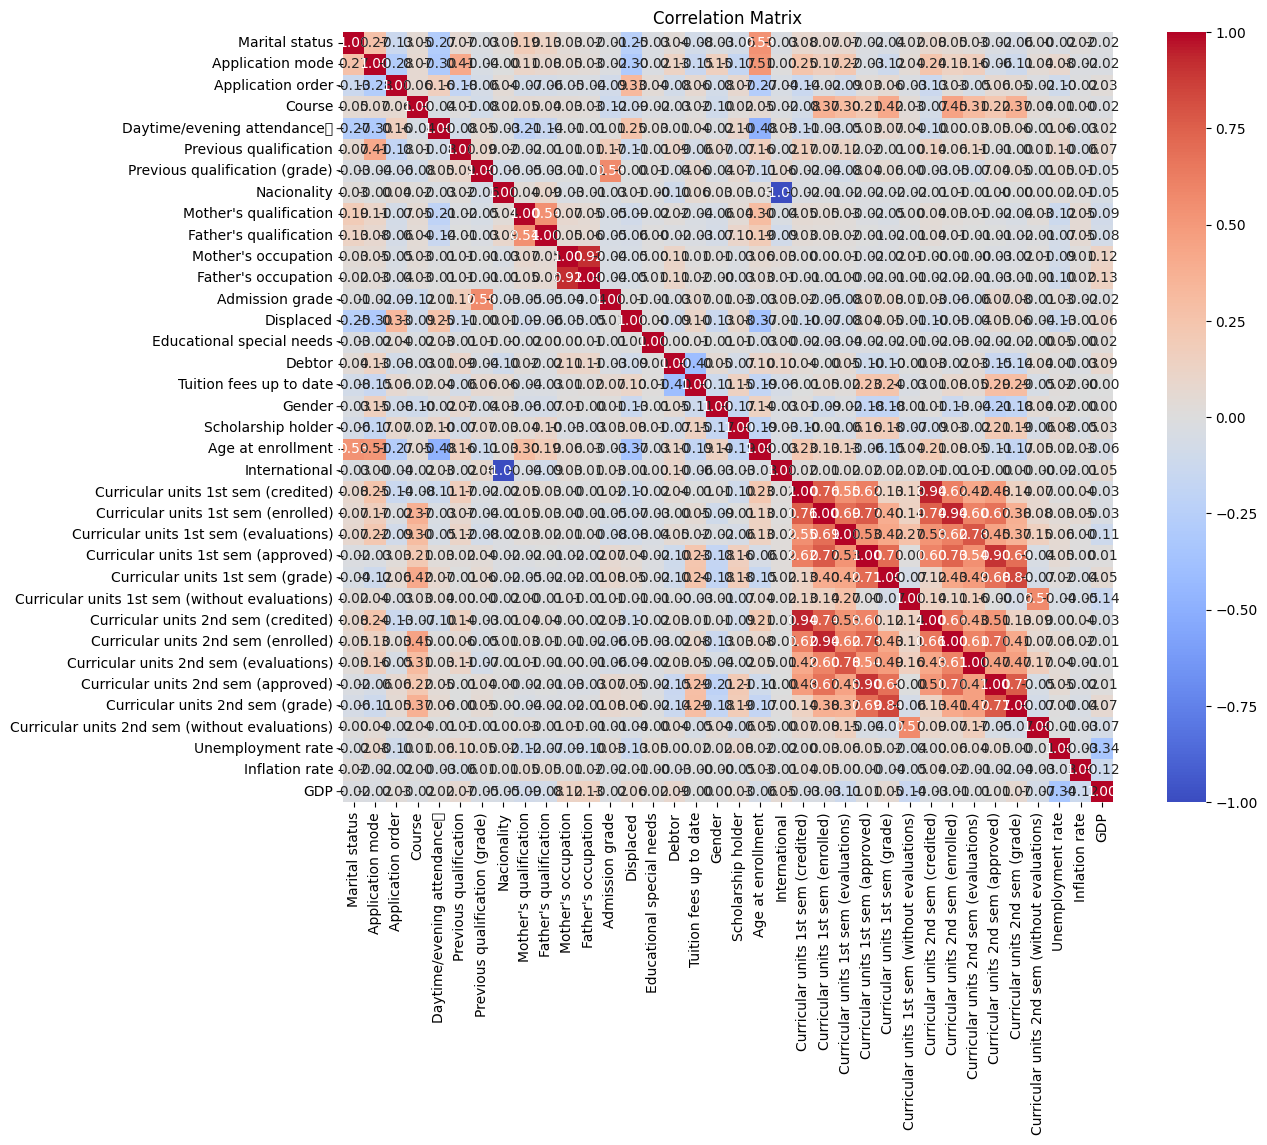

In [59]:
# Calculate the correlation matrix
corr = X_train_scaled.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

### 4.3 Fitting the LR, XGB and RF

In [60]:
### Logistic Regression
log_model = LogisticRegression(C=0.5, penalty='l2', max_iter=1000)
log_model.fit(X_train_scaled, y_train)
log_preds = log_model.predict(X_test_scaled)

log_acc = accuracy_score(y_test, log_preds)
log_f1 = f1_score(y_test, log_preds, average='binary')

scaled_full_X = X.copy()
scaled_full_X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
log_cv_scores = cross_val_score(log_model, scaled_full_X, y, cv=5)

print("\Base Logistic Regression")
print(f"Test Accuracy: {log_acc:.4f}")
print(f"F1 Score (weighted): {log_f1:.4f}")
print(f"Cross-validated Accuracy (mean): {log_cv_scores.mean():.4f}")

### Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds, average='binary')

rf_cv_scores = cross_val_score(rf_model, X, y, cv=5)

print("Base Random Forest")
print(f"Test Accuracy: {rf_acc:.4f}")
print(f"F1 Score (weighted): {rf_f1:.4f}")
print(f"Cross-validated Accuracy (mean): {rf_cv_scores.mean():.4f}")

### XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                          n_estimators=200, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds, average='binary')

xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5)

print("Base XGBoost")
print(f"Test Accuracy: {xgb_acc:.4f}")
print(f"F1 Score (weighted): {xgb_f1:.4f}")
print(f"Cross-validated Accuracy (mean): {xgb_cv_scores.mean():.4f}")

\Base Logistic Regression
Test Accuracy: 0.8655
F1 Score (weighted): 0.7916
Cross-validated Accuracy (mean): 0.8764
Base Random Forest
Test Accuracy: 0.8576
F1 Score (weighted): 0.7758
Cross-validated Accuracy (mean): 0.8752


/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:59:54] WARNING: /Users/runner/

Base XGBoost
Test Accuracy: 0.8565
F1 Score (weighted): 0.7873
Cross-validated Accuracy (mean): 0.8775


/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### 4.4 Plotting the base model results

In [61]:
# Creating the function for the plot

# Projecting the X_test to 2D using t-SNE, so tha tplotting can be done nicely
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_2d = tsne.fit_transform(X_test)

#Creating a function that creates the plot
def plot_true_vs_pred(X_2d, y_true, y_pred, model_name, zoom=None):
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: True Labels
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_true, ax=axes[0],
                    palette='tab10', s=40, edgecolor='k')
    axes[0].set_title(f"{model_name} - True Labels")
    axes[0].legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot 2: Predicted Labels
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_pred, ax=axes[1],
                    palette='tab10', s=40, edgecolor='k')
    axes[1].set_title(f"{model_name} - Predicted Labels")
    axes[1].legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot 3: Misclassifications (True = Red, False = Gray)
    misclassified = y_true != y_pred
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=misclassified, ax=axes[2],
                    palette={True: 'red', False: 'lightgrey'}, s=40, edgecolor='k')
    axes[2].set_title(f"{model_name} - Misclassified Points")
    axes[2].legend(title="Misclassified", labels=["Correct", "Wrong"],
                   bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if zoom:
        for ax in axes:
            ax.set_xlim(zoom[0])
            ax.set_ylim(zoom[1])

    plt.tight_layout()
    plt.show()

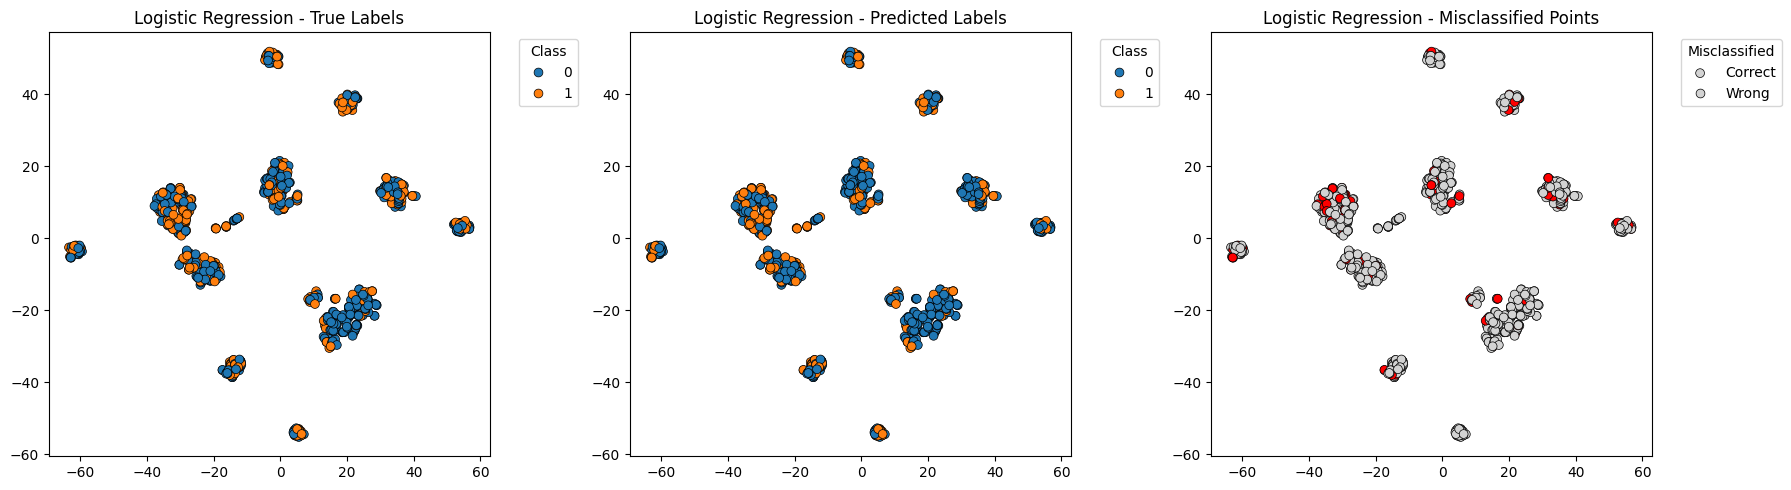

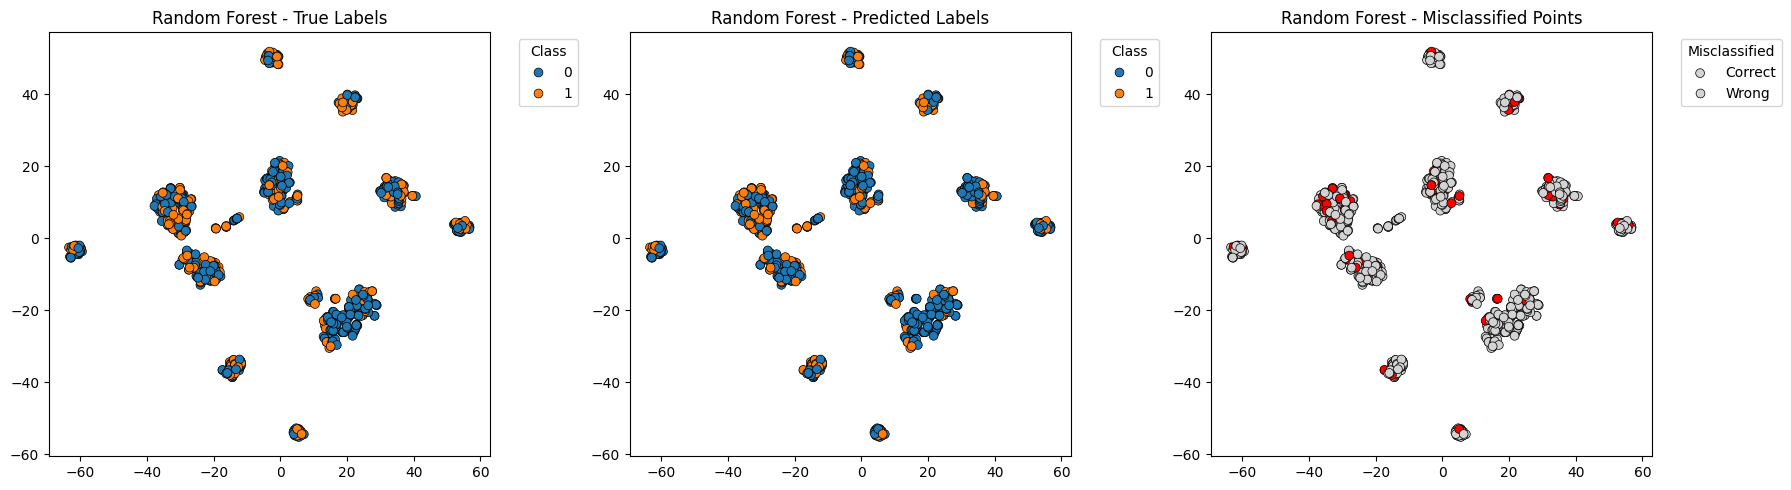

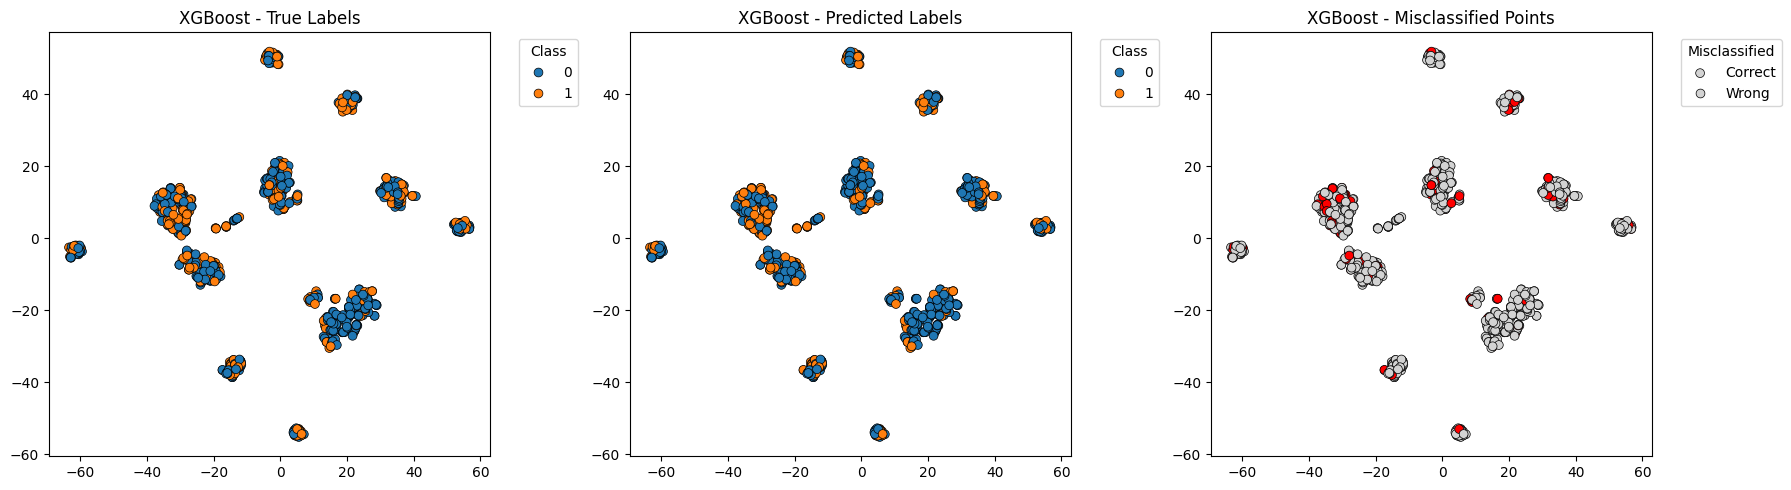

In [27]:
# t-SNE projection
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_2d = tsne.fit_transform(X_test)

# Logistic Regression plot
plot_true_vs_pred(X_2d, y_test, log_preds, "Logistic Regression")

# Random Forest plot
plot_true_vs_pred(X_2d, y_test, rf_preds, "Random Forest")

# XGBoost plot
plot_true_vs_pred(X_2d, y_test, xgb_preds, "XGBoost")


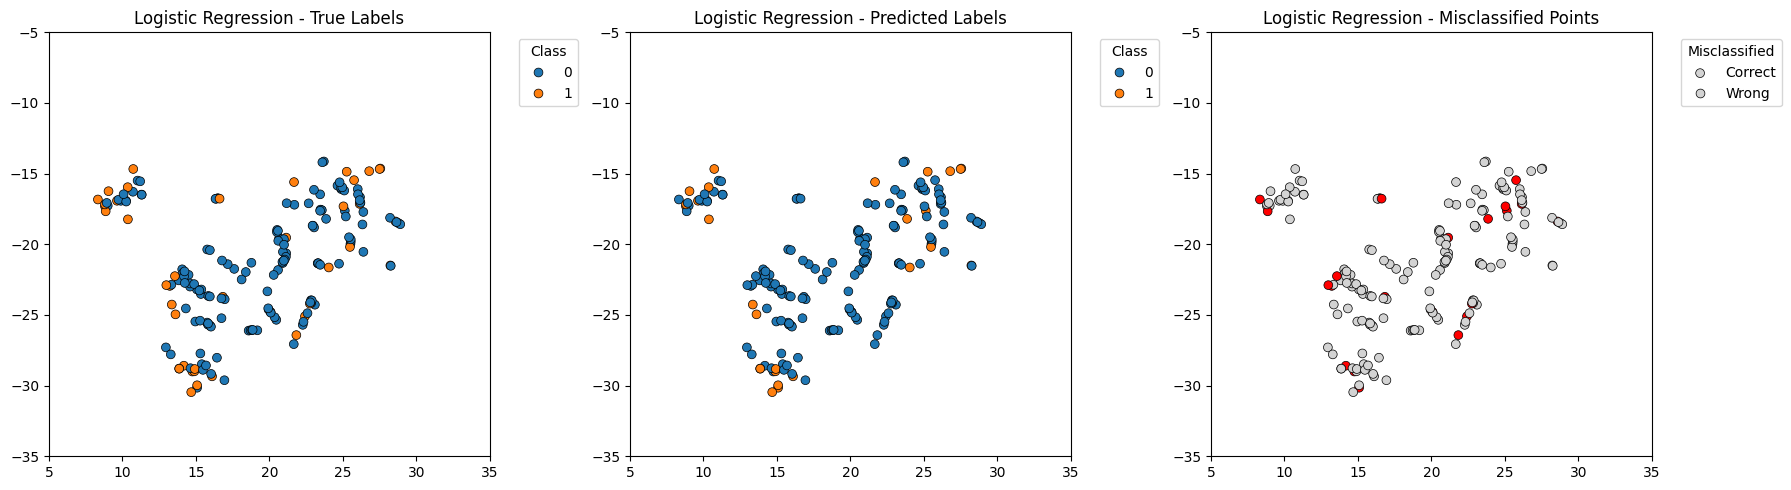

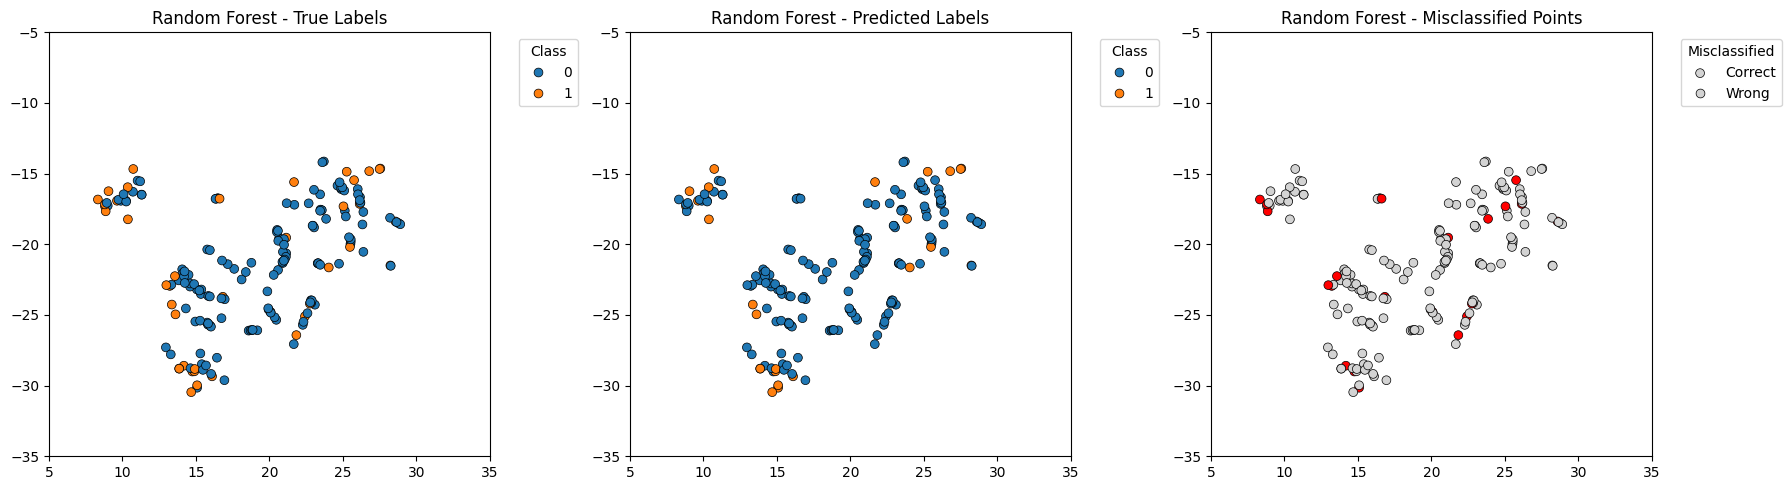

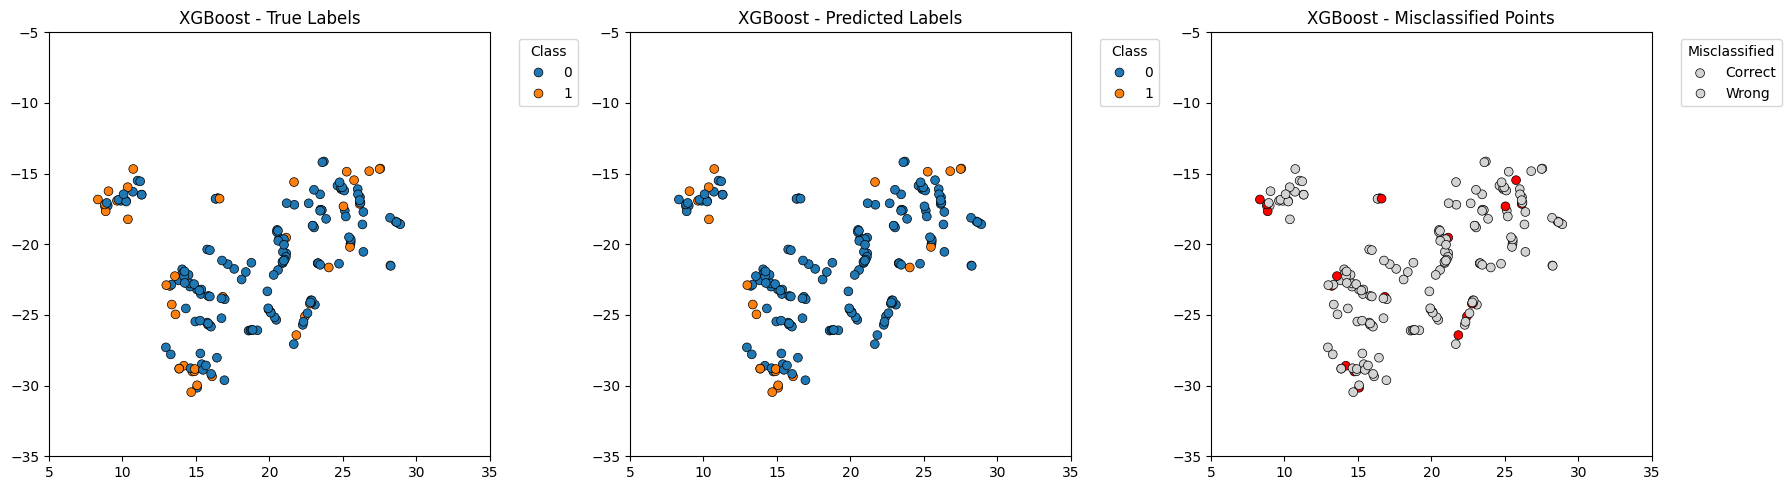

In [28]:
#Selecting specific area on the plot and printing it
 
# Logistic Regression
plot_true_vs_pred(X_2d, y_test, log_preds, "Logistic Regression", zoom=((5, 35),(-35,-5)))

# Random Forest
plot_true_vs_pred(X_2d, y_test, rf_preds, "Random Forest", zoom=((5, 35),(-35,-5)))

# XGBoost (if installed)
plot_true_vs_pred(X_2d, y_test, xgb_preds, "XGBoost", zoom=((5, 35),(-35,-5)))


## 5. Bias/Fairness evaluation of base models

### 5.1 Making sure that the target is binary
We do this to only focus on the drop out predicton

In [62]:
y_test_binary = y_test
log_preds_binary = log_preds
xgb_preds_binary = xgb_preds
rf_preds_binary = rf_preds

### 5.2 Setting the sensitive features

In [63]:
sensitive_feature_gender = X_test[["Gender"]]
sensitive_feature_nationality = X_test[["Nacionality"]]

### 5.3 Equal Opportunity Difference 

In [64]:
def evaluate_equal_opportunity_diff(y_true_binary, y_pred_binary, sensitive_features, model_name, sensitive_feature_name):
    if sensitive_feature_name.lower() == "nationality":
        # Fixed grouping: code 1 is majority
        sensitive_features = sensitive_features.apply(lambda x: "Majority" if x == 1 else "Minority")
    elif sensitive_feature_name.lower() == "gender":
        # Optionally map gender codes to labels (if coded as 0/1 or other numeric codes)
        sensitive_features = sensitive_features  # no transformation if already clear labels
    else:
        raise ValueError("Unsupported sensitive feature name")
    
    metric_frame = MetricFrame(metrics=true_positive_rate,
                               y_true=y_true_binary,
                               y_pred=y_pred_binary,
                               sensitive_features=sensitive_features)
    
    # print(f"\n=== {model_name} - True Positive Rate by {sensitive_feature_name} ===")
    # print(metric_frame.by_group)
    
    eo_diff = metric_frame.difference()
    
    print(f"{model_name} - Equal Opportunity Difference ({sensitive_feature_name}): {eo_diff:.4f}")
    
    return eo_diff

In [70]:
# Gender fairness
eo_diff_log_gender = evaluate_equal_opportunity_diff(y_test_binary, log_preds_binary, X_test["Gender"], "Logistic Regression", "Gender")
print(" ")
eo_diff_rf_gender = evaluate_equal_opportunity_diff(y_test_binary, rf_preds_binary, X_test["Gender"], "Random Forest", "Gender")
print(" ")

eo_diff_xgb_gender = evaluate_equal_opportunity_diff(y_test_binary, xgb_preds_binary, X_test["Gender"], "XGBoost", "Gender")
print(" ")
print(" ")

# Nationality fairness
eo_diff_log_nat = evaluate_equal_opportunity_diff(y_test_binary, log_preds_binary, X_test["Nacionality"], "Logistic Regression", "Nationality")
print(" ")
eo_diff_rf_nat = evaluate_equal_opportunity_diff(y_test_binary, rf_preds_binary, X_test["Nacionality"], "Random Forest", "Nationality")
print(" ")
eo_diff_xgb_nat = evaluate_equal_opportunity_diff(y_test_binary, xgb_preds_binary, X_test["Nacionality"], "XGBoost", "Nationality")

Logistic Regression - Equal Opportunity Difference (Gender): 0.0941
 
Random Forest - Equal Opportunity Difference (Gender): 0.0830
 
XGBoost - Equal Opportunity Difference (Gender): 0.0733
 
 
Logistic Regression - Equal Opportunity Difference (Nationality): 0.0009
 
Random Forest - Equal Opportunity Difference (Nationality): 0.3172
 
XGBoost - Equal Opportunity Difference (Nationality): 0.2621


### 5.4 Demograpic Parity

In [ ]:
def evaluate_demographic_parity_diff(y_true_binary, y_pred_binary, sensitive_features, model_name, sensitive_feature_name):
    # Group nationality into Majority/Minority if needed
    if sensitive_feature_name.lower() == "nationality":
        # Map: 1 = Majority, else = Minority
        sensitive_features = sensitive_features.apply(lambda x: "Majority" if x == 1 else "Minority")
        
    metric_frame = MetricFrame(metrics=selection_rate,
                               y_true=y_true_binary,
                               y_pred=y_pred_binary,
                               sensitive_features=sensitive_features)
    
    # print(f"\n=== {model_name} - Selection Rate by {sensitive_feature_name} ===")
    # print(metric_frame.by_group)
    
    dp_diff = metric_frame.difference()
    
    print(f"{model_name} - Demographic Parity Difference ({sensitive_feature_name}): {dp_diff:.4f}")
    
    return dp_diff

In [72]:
dp_diff_log_gender = evaluate_demographic_parity_diff(y_test_binary, log_preds_binary, X_test["Gender"], "Logistic Regression", "Gender")
print(" ")
dp_diff_rf_gender = evaluate_demographic_parity_diff(y_test_binary, rf_preds_binary, X_test["Gender"], "Random Forest", "Gender")
print(" ")
dp_diff_xgb_gender = evaluate_demographic_parity_diff(y_test_binary, xgb_preds_binary, X_test["Gender"], "XGBoost", "Gender")
print(" ")
print(" ")
dp_diff_log_nat = evaluate_demographic_parity_diff(y_test_binary, log_preds_binary, X_test["Nacionality"], "Logistic Regression", "Nationality")
print(" ")
dp_diff_rf_nat = evaluate_demographic_parity_diff(y_test_binary, rf_preds_binary, X_test["Nacionality"], "Random Forest", "Nationality")
print(" ")
dp_diff_xgb_nat = evaluate_demographic_parity_diff(y_test_binary, xgb_preds_binary, X_test["Nacionality"], "XGBoost", "Nationality")
print(" ")

Logistic Regression - Demographic Parity Difference (Gender): 0.2777
 
Random Forest - Demographic Parity Difference (Gender): 0.2676
 
XGBoost - Demographic Parity Difference (Gender): 0.2640
 
 
Logistic Regression - Demographic Parity Difference (Nationality): 0.0726
 
Random Forest - Demographic Parity Difference (Nationality): 0.0271
 
XGBoost - Demographic Parity Difference (Nationality): 0.0311
 


### 5.5 Equalized Odds

In [73]:
def evaluate_equalized_odds_diff(y_true_binary, y_pred_binary, sensitive_features, model_name, sensitive_feature_name):
    # Group nationality into Majority/Minority if needed
    if sensitive_feature_name.lower() == "nationality":
        # Map: 1 → Majority, else → Minority
        sensitive_features = sensitive_features.apply(lambda x: "Majority" if x == 1 else "Minority")
    
    # MetricFrame with TPR and FPR
    metric_frame = MetricFrame(metrics={'TPR': true_positive_rate, 'FPR': false_positive_rate},
                               y_true=y_true_binary,
                               y_pred=y_pred_binary,
                               sensitive_features=sensitive_features)
    
    # print(f"\n=== {model_name} - True Positive Rate by {sensitive_feature_name} ===")
    # print(metric_frame.by_group['TPR'])
    
    # print(f"\n=== {model_name} - False Positive Rate by {sensitive_feature_name} ===")
    # print(metric_frame.by_group['FPR'])
    
    # Equalized Odds Difference = max difference of TPR and FPR across groups
    eo_diff = max(metric_frame.difference(method='between_groups')['TPR'],
                  metric_frame.difference(method='between_groups')['FPR'])
    
    print(f"{model_name} - Equalized Odds Difference ({sensitive_feature_name}): {eo_diff:.4f}")
    
    return eo_diff

In [74]:
eo_diff_log_gender = evaluate_equalized_odds_diff(y_test_binary, log_preds_binary, X_test["Gender"], "Logistic Regression", "Gender")
print(" ")
eo_diff_rf_gender = evaluate_equalized_odds_diff(y_test_binary, rf_preds_binary, X_test["Gender"], "Random Forest", "Gender")
print(" ")
eo_diff_xgb_gender = evaluate_equalized_odds_diff(y_test_binary, xgb_preds_binary, X_test["Gender"], "XGBoost", "Gender")
print(" ")
print(" ")

eo_diff_log_nat = evaluate_equalized_odds_diff(y_test_binary, log_preds_binary, X_test["Nacionality"], "Logistic Regression", "Nationality")
print(" ")
eo_diff_rf_nat = evaluate_equalized_odds_diff(y_test_binary, rf_preds_binary, X_test["Nacionality"], "Random Forest", "Nationality")
print(" ")
eo_diff_xgb_nat = evaluate_equalized_odds_diff(y_test_binary, xgb_preds_binary, X_test["Nacionality"], "XGBoost", "Nationality")

Logistic Regression - Equalized Odds Difference (Gender): 0.0941
 
Random Forest - Equalized Odds Difference (Gender): 0.0928
 
XGBoost - Equalized Odds Difference (Gender): 0.0809
 
 
Logistic Regression - Equalized Odds Difference (Nationality): 0.0524
 
Random Forest - Equalized Odds Difference (Nationality): 0.3172
 
XGBoost - Equalized Odds Difference (Nationality): 0.2621


### 5.6 Plotting the results

In [75]:
def plot_bootstrapped_fairness(y_true, y_pred, sensitive_attr, model_name, sensitive_attr_name, pos_label=0, n_boot=1000):
    # Binarize
    y_true_bin = pd.Series((y_true == pos_label).astype(int)).reset_index(drop=True)
    y_pred_bin = pd.Series((y_pred == pos_label).astype(int)).reset_index(drop=True)
    sensitive_attr = pd.Series(sensitive_attr).reset_index(drop=True)

    # Store bootstrap results per metric
    results = {"EO Diff": [], "DP Diff": [], "Equalized Odds Diff": []}

    for _ in range(n_boot):
        idx = resample(range(len(y_true_bin)), replace=True)
        y_boot = y_true_bin.iloc[idx]
        pred_boot = y_pred_bin.iloc[idx]
        s_boot = sensitive_attr.iloc[idx]

        # True Positive Rates per group
        try:
            tpr_0 = true_positive_rate(y_boot[s_boot == 0], pred_boot[s_boot == 0])
            tpr_1 = true_positive_rate(y_boot[s_boot == 1], pred_boot[s_boot == 1])
        except:
            tpr_0, tpr_1 = np.nan, np.nan

        # Selection Rates per group (for Demographic Parity)
        try:
            sr_0 = selection_rate(y_boot[s_boot == 0], pred_boot[s_boot == 0])
            sr_1 = selection_rate(y_boot[s_boot == 1], pred_boot[s_boot == 1])
        except:
            sr_0, sr_1 = np.nan, np.nan

        # Equalized Odds → difference in both TPR and FPR
        try:
            from fairlearn.metrics import false_positive_rate
            fpr_0 = false_positive_rate(y_boot[s_boot == 0], pred_boot[s_boot == 0])
            fpr_1 = false_positive_rate(y_boot[s_boot == 1], pred_boot[s_boot == 1])
            eq_odds_diff = max(abs(tpr_1 - tpr_0), abs(fpr_1 - fpr_0))
        except:
            eq_odds_diff = np.nan

        # Store diffs if valid
        if not np.isnan(tpr_0) and not np.isnan(tpr_1):
            results["EO Diff"].append(tpr_1 - tpr_0)
        if not np.isnan(sr_0) and not np.isnan(sr_1):
            results["DP Diff"].append(sr_1 - sr_0)
        if not np.isnan(eq_odds_diff):
            results["Equalized Odds Diff"].append(eq_odds_diff)

    # Plot all metrics in the same figure
    plt.figure(figsize=(12, 6))

    for i, (metric_name, diffs) in enumerate(results.items()):
        plt.hist(diffs, bins=30, alpha=0.5, density=True, label=f"{metric_name} (mean={np.mean(diffs):.3f})", edgecolor='black')

    plt.axvline(0, color='black', linestyle='--', label="No Difference")
    plt.title(f"Fairness Metrics (EO, DP, Equalized Odds) for {sensitive_attr_name}\nModel: {model_name}", fontsize=14)
    plt.xlabel("Metric Difference")
    plt.ylabel("Bootstrap Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

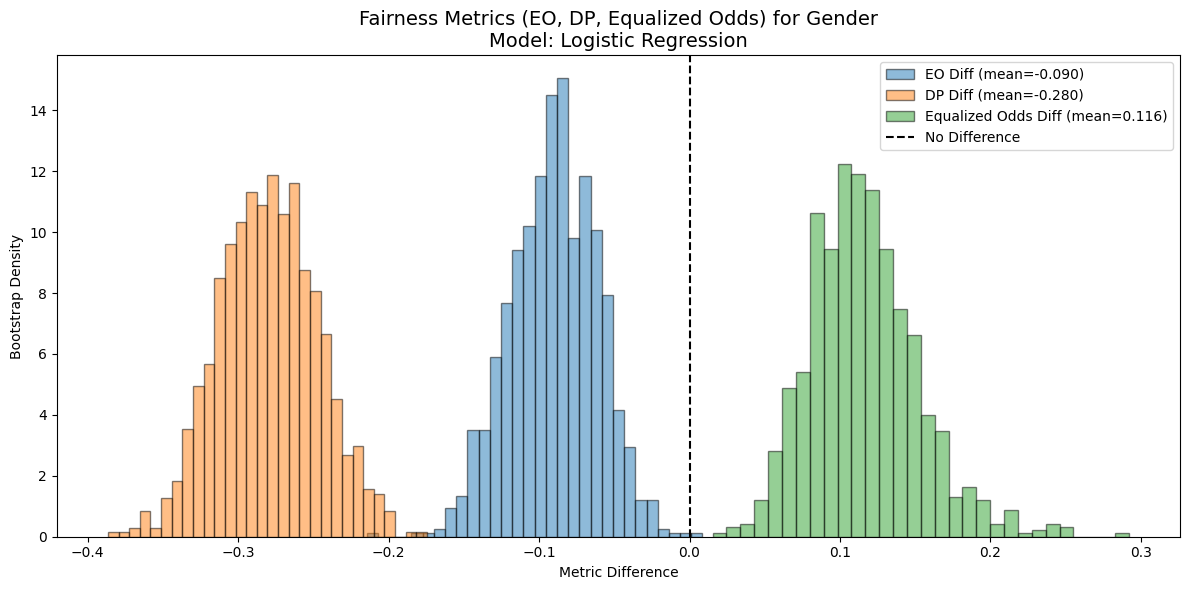

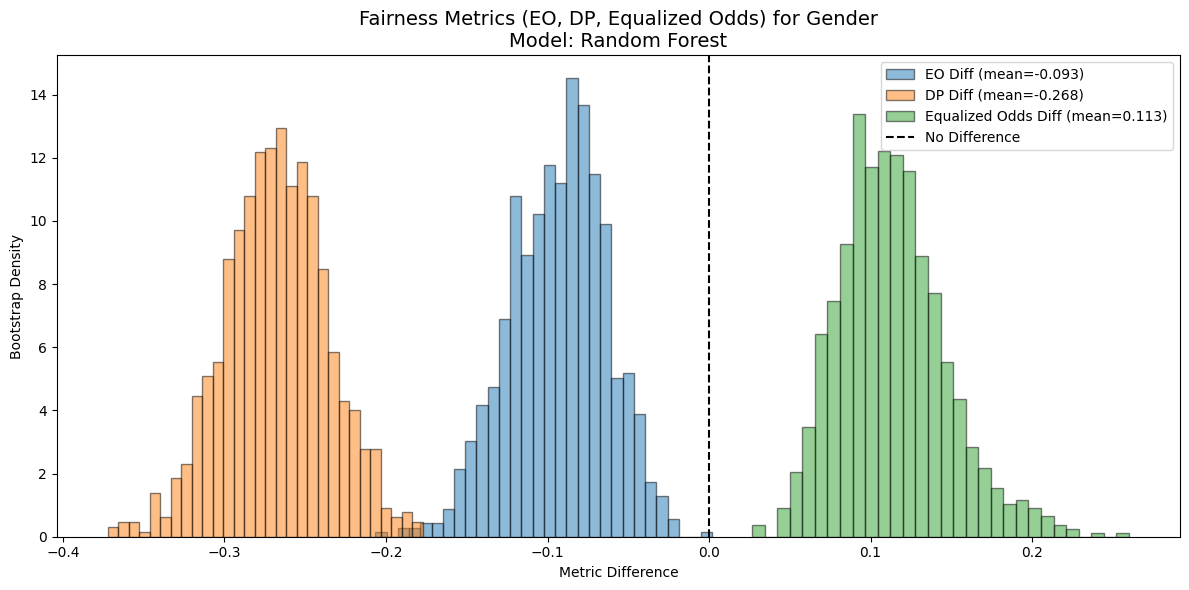

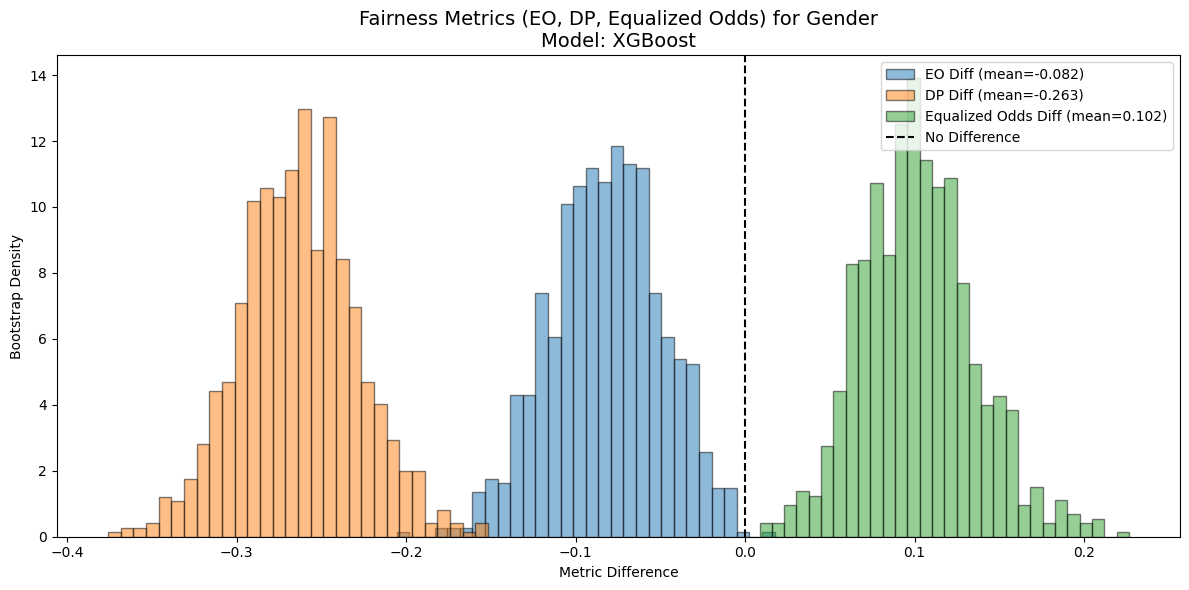

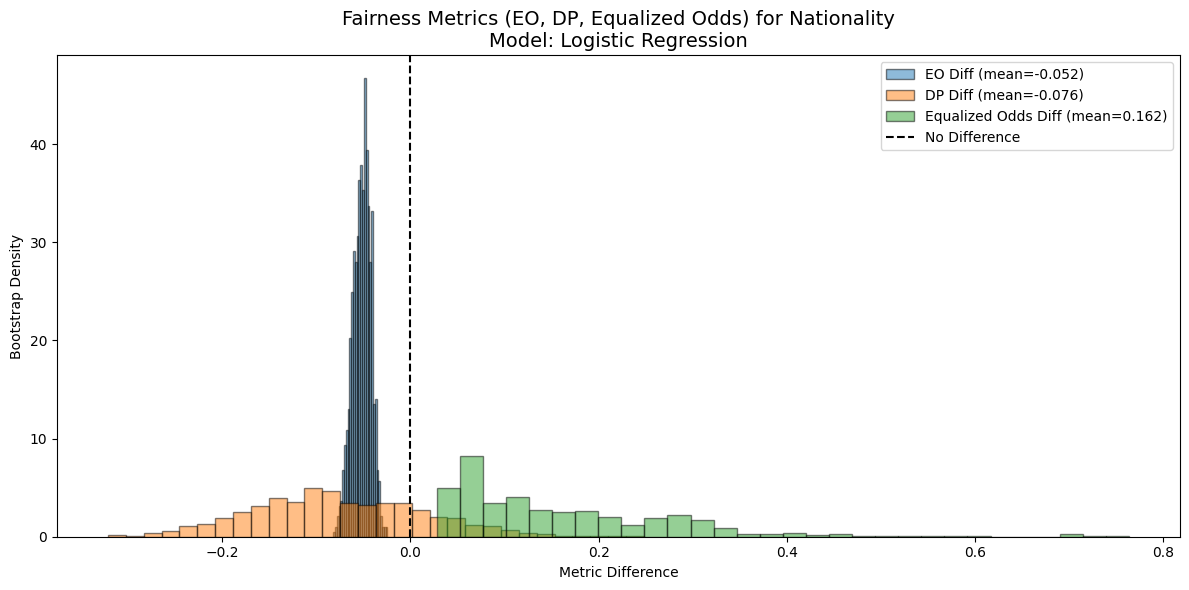

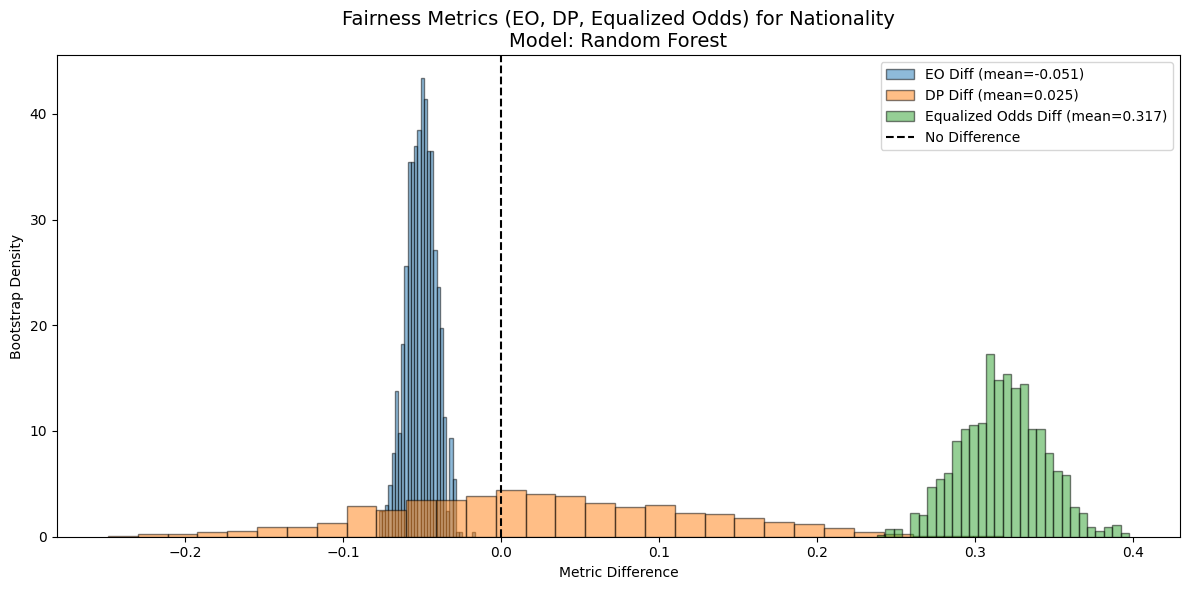

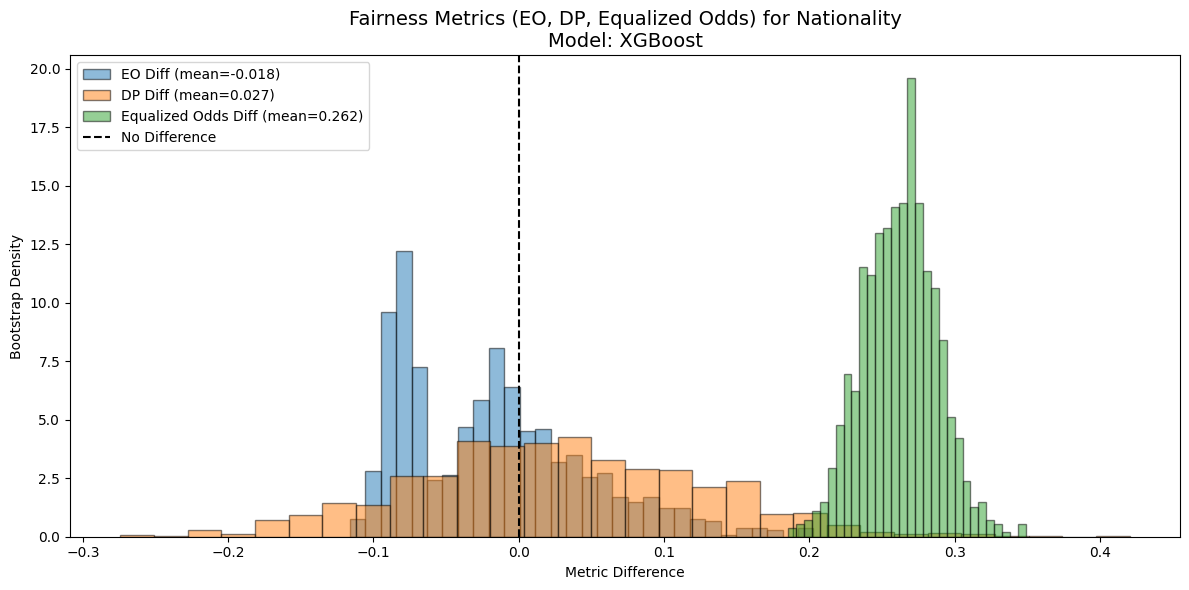

In [76]:
# Plotting gender
plot_bootstrapped_fairness(y_test, log_preds, X_test["Gender"], "Logistic Regression", "Gender")
plot_bootstrapped_fairness(y_test, rf_preds, X_test["Gender"], "Random Forest", "Gender")
plot_bootstrapped_fairness(y_test, xgb_preds, X_test["Gender"], "XGBoost", "Gender")

# Plotting nationality
nat_grouped = X_test["Nacionality"].apply(lambda x: 1 if x == 1 else 0)

plot_bootstrapped_fairness(y_test, log_preds, nat_grouped, "Logistic Regression", "Nationality")
plot_bootstrapped_fairness(y_test, rf_preds, nat_grouped, "Random Forest", "Nationality")
plot_bootstrapped_fairness(y_test, xgb_preds, nat_grouped, "XGBoost", "Nationality")


## 6. Pre-processing

#### 6.1 Reweighing
Done for XGB, LR, RF

In [78]:
# Adding sensitive feaatures to X train
Xy_train = X_train.copy()
Xy_train['target'] = y_train

# Computing observed probabilities
group_cols = ['Gender', 'Nacionality']
group_counts = Xy_train.groupby(group_cols + ['target']).size().reset_index(name='count')
total_count = len(Xy_train)

# P(S,A): probability of sensitive group
group_totals = Xy_train.groupby(group_cols).size().reset_index(name='group_count')
group_probs = pd.merge(group_counts, group_totals, on=group_cols)
group_probs['p_sa'] = group_probs['count'] / total_count
group_probs['p_s'] = group_probs['group_count'] / total_count

# P(Y): overall label probabilities
label_counts = Xy_train['target'].value_counts(normalize=True).to_dict()

# Expected probability assuming independence
group_probs['p_expected'] = group_probs['p_s'] * group_probs['target'].map(label_counts)

# Weight = expected / observed
group_probs['weight'] = group_probs['p_expected'] / group_probs['p_sa']

# Mapping weights back to each sample
# Merge weights into training set
Xy_train = pd.merge(
    Xy_train,
    group_probs[group_cols + ['target', 'weight']],
    on=group_cols + ['target'],
    how='left'
)

# Sample weights ready
sample_weights = Xy_train['weight'].values

# Drop target column for training
X_train_weighted = Xy_train.drop(columns=['target', 'weight'])

X_train_weighted_scaled = X_train_weighted.copy()
X_train_weighted_scaled[numeric_cols] = scaler.transform(X_train_weighted[numeric_cols])


#### 6.2 Retraining and predicting on reweighted data

In [79]:
log_model_rw = LogisticRegression(max_iter=1000)
log_model_rw.fit(X_train_weighted, y_train, sample_weight=sample_weights)

rf_model_rw = RandomForestClassifier(random_state=42)
rf_model_rw.fit(X_train_weighted, y_train, sample_weight=sample_weights)

xgb_model_rw = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model_rw.fit(X_train_weighted, y_train, sample_weight=sample_weights)

/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [80]:
# Predictions
log_preds_rw = log_model_rw.predict(X_test)
rf_preds_rw = rf_model_rw.predict(X_test)
xgb_preds_rw = xgb_model_rw.predict(X_test)

# Metrics
print("Reweighed Logistic Regression")
print(f"Accuracy: {accuracy_score(y_test, log_preds_rw):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, log_preds_rw, average='weighted'):.4f}")
print(" ")
print("Reweighed Random Forest")
print(f"Accuracy: {accuracy_score(y_test, rf_preds_rw):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, rf_preds_rw, average='weighted'):.4f}")
print(" ")
print("Reweighed XGBoost")
print(f"Accuracy: {accuracy_score(y_test, xgb_preds_rw):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, xgb_preds_rw, average='weighted'):.4f}")


Reweighed Logistic Regression
Accuracy: 0.8429
F1 Score (weighted): 0.8378
 
Reweighed Random Forest
Accuracy: 0.8588
F1 Score (weighted): 0.8548
 
Reweighed XGBoost
Accuracy: 0.8588
F1 Score (weighted): 0.8563


#### 6.3 DP and EO for reweighted models

In [81]:
dp_diff_log_rw_gender = evaluate_demographic_parity_diff(y_test, log_preds_rw, X_test["Gender"], "Logistic Regression", "Gender")
print(" ")
dp_diff_rf_rw_gender = evaluate_demographic_parity_diff(y_test, rf_preds_rw, X_test["Gender"], "Random Forest", "Gender")
print(" ")
dp_diff_xgb_rw_gender = evaluate_demographic_parity_diff(y_test, xgb_preds_rw, X_test["Gender"], "XGBoost", "Gender")

Logistic Regression - Demographic Parity Difference (Gender): 0.2456
 
Random Forest - Demographic Parity Difference (Gender): 0.2523
 
XGBoost - Demographic Parity Difference (Gender): 0.2539


In [82]:
eo_diff_log_rw_nat = evaluate_equalized_odds_diff(y_test, log_preds_rw, X_test["Nacionality"], "Logistic Regression", "Nationality")
print(" ")
eo_diff_rf_rw_nat = evaluate_equalized_odds_diff(y_test, rf_preds_rw, X_test["Nacionality"], "Random Forest", "Nationality")
print(" ")
eo_diff_xgb_rw_nat = evaluate_equalized_odds_diff(y_test, xgb_preds_rw, X_test["Nacionality"], "XGBoost", "Nationality")

Logistic Regression - Equalized Odds Difference (Nationality): 0.1905
 
Random Forest - Equalized Odds Difference (Nationality): 0.3010
 
XGBoost - Equalized Odds Difference (Nationality): 0.2686


## 7. In-Processing
Only for LR

#### 7.1 Inprocessing for Gender

In [83]:
# Sensitive feature: Gender
sensitive_features_gender = X_train_weighted["Gender"]

# Base estimator
lr_base = LogisticRegression(solver='liblinear', max_iter=1000)

# Exponentiated Gradient with Demographic Parity constraint
mitigator_gender_dp = ExponentiatedGradient(
    estimator=lr_base,
    constraints=DemographicParity(),
)

# Fit using sample weights from reweighing
mitigator_gender_dp.fit(X_train_weighted, y_train, sensitive_features=sensitive_features_gender)


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x189b94580>,
                      estimator=LogisticRegression(max_iter=1000,
                                                   solver='liblinear'),
                      nu=0.0027213827697616143)

In [84]:
# Predict
log_preds_gender_dp = mitigator_gender_dp.predict(X_test)


# Evaluate
acc_gender_dp = accuracy_score(y_test, log_preds_gender_dp)
f1_gender_dp = f1_score(y_test, log_preds_gender_dp, average='weighted')

print("Logistic Regression: Reweighing + Demographic Parity on Gender")
print(f"Accuracy: {acc_gender_dp:.4f}")
print(f"F1 Score (weighted): {f1_gender_dp:.4f}")


Logistic Regression: Reweighing + Demographic Parity on Gender
Accuracy: 0.8339
F1 Score (weighted): 0.8293


#### 7.2 Inprocessing for Nationality

In [85]:
# Sensitive feature: Nationality
sensitive_features_nat = X_train_weighted["Nacionality"]

# Exponentiated Gradient with Equalized Odds constraint
mitigator_nat_eqodds = ExponentiatedGradient(
    estimator=lr_base,
    constraints=EqualizedOdds()
)

mitigator_nat_eqodds.fit(X_train_weighted, y_train, sensitive_features=sensitive_features_nat)


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x1893e22b0>,
                      estimator=LogisticRegression(max_iter=1000,
                                                   solver='liblinear'),
                      nu=0.0027185846474035683)

In [86]:
# Predict

log_preds_nat_eqodds = mitigator_nat_eqodds.predict(X_test)

acc_nat_eqodds = accuracy_score(y_test, log_preds_nat_eqodds)
f1_nat_eqodds = f1_score(y_test, log_preds_nat_eqodds, average='weighted')

print("Logistic Regression: Reweighing + Equalized Odds on Nationality")
print(f"Accuracy: {acc_nat_eqodds:.4f}")
print(f"F1 Score (weighted): {f1_nat_eqodds:.4f}")


Logistic Regression: Reweighing + Equalized Odds on Nationality
Accuracy: 0.8486
F1 Score (weighted): 0.8435


## 8. Post-processing
Only XGB and RF

#### 8.1 Post-processing for Nationality

In [87]:
# Binarize nationality
nat_test_bin = X_test["Nacionality"].apply(lambda x: "Majority" if x == 1 else "Minority")

# Build DataFrame to inspect label balance
nat_df = pd.DataFrame({
    "nat_bin": nat_test_bin,
    "target": y_test
})

valid_nat_groups = (
    nat_df.groupby("nat_bin")["target"]
    .nunique()
    .reset_index()
    .query("target == 2")["nat_bin"]
    .tolist()
)

valid_mask = nat_test_bin.isin(valid_nat_groups)
X_test_valid = X_test[valid_mask]
y_test_valid = y_test[valid_mask]
nat_test_bin_valid = nat_test_bin[valid_mask]


In [88]:
### Random Forest
to_rf_nat_eqodds = ThresholdOptimizer(
    estimator=rf_model_rw,
    constraints="equalized_odds",
    prefit=True
)
to_rf_nat_eqodds.fit(X_test_valid, y_test_valid, sensitive_features=nat_test_bin_valid)
rf_preds_nat_eqodds = to_rf_nat_eqodds.predict(X_test, sensitive_features=nat_test_bin)

print("Random Forest: Reweighing + Equalized Odds on Nationality")
print(f"Accuracy: {accuracy_score(y_test, rf_preds_nat_eqodds):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, rf_preds_nat_eqodds, average='weighted'):.4f}")

### XGBoost
to_xgb_nat_eqodds = ThresholdOptimizer(
    estimator=xgb_model_rw,
    constraints="equalized_odds",
    prefit=True
)
to_xgb_nat_eqodds.fit(X_test_valid, y_test_valid, sensitive_features=nat_test_bin_valid)
xgb_preds_nat_eqodds = to_xgb_nat_eqodds.predict(X_test, sensitive_features=nat_test_bin)

print("XGBoost: Reweighing + Equalized Odds on Nationality")
print(f"Accuracy: {accuracy_score(y_test, xgb_preds_nat_eqodds):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, xgb_preds_nat_eqodds, average='weighted'):.4f}")

Random Forest: Reweighing + Equalized Odds on Nationality
Accuracy: 0.8655
F1 Score (weighted): 0.8625
XGBoost: Reweighing + Equalized Odds on Nationality
Accuracy: 0.8644
F1 Score (weighted): 0.8634


/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         1.         1.         0.
 0.         0.         1.         0.         0.         1.
 0.         1.         0.         1.         1.         0.
 0.         0.         0.         0.         1.         1.
 0.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 1.         0.         0.         0.         0.         0.97444444
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         1.
 0.       

Calibrated Equalized Odds (Nationality on Reweighed RF & XGB)

#### 8.2 Post-processing for Gender

In [89]:
gender_test_bin = X_test["Gender"]

# Inspect label distribution
gender_df = pd.DataFrame({
    "gender_bin": gender_test_bin,
    "target": y_test
})
valid_gender_groups = (
    gender_df.groupby("gender_bin")["target"]
    .nunique()
    .reset_index()
    .query("target == 2")["gender_bin"]
    .tolist()
)

# Filter to valid gender groups
valid_mask = gender_test_bin.isin(valid_gender_groups)
X_test_valid = X_test[valid_mask]
y_test_valid = y_test[valid_mask]
gender_test_bin_valid = gender_test_bin[valid_mask]

In [ ]:
### Random Forest
to_rf_gender_dp = ThresholdOptimizer(
    estimator=rf_model_rw,
    constraints="demographic_parity",
    prefit=True
)
to_rf_gender_dp.fit(X_test_valid, y_test_valid, sensitive_features=gender_test_bin_valid)
rf_preds_gender_dp = to_rf_gender_dp.predict(X_test, sensitive_features=gender_test_bin)

print("Random Forest: Reweighing + Demographic Parity on Gender")
print(f"Accuracy: {accuracy_score(y_test, rf_preds_gender_dp):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, rf_preds_gender_dp, average='weighted'):.4f}")

### XGBoost
to_xgb_gender_dp = ThresholdOptimizer(
    estimator=xgb_model_rw,
    constraints="demographic_parity",
    prefit=True
)
to_xgb_gender_dp.fit(X_test_valid, y_test_valid, sensitive_features=gender_test_bin_valid)
xgb_preds_gender_dp = to_xgb_gender_dp.predict(X_test, sensitive_features=gender_test_bin)

print("XGBoost: Reweighing + Demographic Parity on Gender")
print(f"Accuracy: {accuracy_score(y_test, xgb_preds_gender_dp):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, xgb_preds_gender_dp, average='weighted'):.4f}")

Random Forest: Reweighing + Demographic Parity on Gender
Accuracy: 0.8090
F1 Score (weighted): 0.7949
XGBoost: Reweighing + Demographic Parity on Gender
Accuracy: 0.8056
F1 Score (weighted): 0.7964


/Users/natalialatinovic/opt/anaconda3/envs/thesis-fairenv/lib/python3.9/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.        0.        0.        1.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        1.        0.        0.        1.        0.        0.
 0.        1.        0.        0.        0.        1.        0.
 0.        0.        0.        0.        1.        0.        0.
 0.        0.        0.        0.        1.        1.        0.
 0.        0.        1.        0.        0.        0.        0.
 0.        0.        1.        0.        0.        1.        0.
 0.        0.        1.        1.        0.        1.        0.
 0.        0.        0.        0.        0.0010625 1.        1.
 0.0010625 0.        0.        0.        1.        0.        0.
 0.        0.        0

## 9. Fairness Metrics of Final Fairness-Aware Models

#### 7.2 Demograpic Parity
only on gender for LR, on the in processed model

In [91]:
dp_diff_log_fair_gender = evaluate_demographic_parity_diff(y_test, log_preds_gender_dp, X_test["Gender"], "Logistic Regression", "Gender")
print(" ")
dp_diff_rf_rw_gender = evaluate_demographic_parity_diff(y_test, rf_preds_gender_dp, X_test["Gender"], "Random Forest", "Gender")
print(" ")
dp_diff_xgb_rw_gender = evaluate_demographic_parity_diff(y_test, xgb_preds_gender_dp, X_test["Gender"], "XGBoost", "Gender")

Logistic Regression - Demographic Parity Difference (Gender): 0.1001
 
Random Forest - Demographic Parity Difference (Gender): 0.0006
 
XGBoost - Demographic Parity Difference (Gender): 0.0004


#### 7.3 Equalized Odds
Only in processed nationality for LR

In [92]:
eo_diff_log_fair_nat = evaluate_equalized_odds_diff(y_test, log_preds_nat_eqodds, X_test["Nacionality"], "Logistic Regression", "Nationality")
print(" ")
eo_diff_rf_rw_nat = evaluate_equalized_odds_diff(y_test, rf_preds_nat_eqodds, X_test["Nacionality"], "Random Forest", "Nationality")
print(" ")
eo_diff_xgb_rw_nat = evaluate_equalized_odds_diff(y_test, xgb_preds_nat_eqodds, X_test["Nacionality"], "XGBoost", "Nationality")
print(" ")

Logistic Regression - Equalized Odds Difference (Nationality): 0.1840
 
Random Forest - Equalized Odds Difference (Nationality): 0.1290
 
XGBoost - Equalized Odds Difference (Nationality): 0.2265
 


## 8. Accuracy vs Fainess trade off

In [ ]:
def plot_accuracy_fairness_tradeoff(accuracy_base, accuracy_fair,
                                    fairness_base, fairness_fair,
                                    fairness_metric_name, sensitive_feature_name,
                                    fair_labels):

    model_colors = {'LR': 'green', 'RF': 'red', 'XGB': 'blue'}
    model_names = {'LR': 'Logistic Regression', 'RF': 'Random Forest', 'XGB': 'XGBoost'}

    plt.figure(figsize=(8, 6))

    for model in ['LR', 'RF', 'XGB']:
        color = model_colors[model]
        model_name = model_names[model]

        # Plot base model
        plt.scatter(fairness_base[model], accuracy_base[model], 
                    marker='o', s=100, color=color, edgecolors='black',
                    label=f'{model_name} (Base)')

        # Plot fair model
        plt.scatter(fairness_fair[model], accuracy_fair[model], 
                    marker='x', s=100, color=color,
                    label=f'{model_name} ({fair_labels[model]})')

        # Connect them
        plt.plot([fairness_base[model], fairness_fair[model]],
                 [accuracy_base[model], accuracy_fair[model]],
                 linestyle='--', color=color)

    plt.xlabel(f'{fairness_metric_name} ({sensitive_feature_name})', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'Accuracy vs {fairness_metric_name} ({sensitive_feature_name})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

In [98]:
# Data filled in manually from the scores above

accuracy_base = {'LR': 0.8655, 'RF': 0.8576, 'XGB': 0.8565}
accuracy_fair_gen = {'LR': 0.8339, 'RF': 0.8090, 'XGB': 0.8056}
accuracy_fair_nat = {'LR': 0.8486, 'RF': 0.8655, 'XGB': 0.8644}

demographic_parity_base = {'LR': 0.2777, 'RF': 0.2676, 'XGB': 0.2640}
demographic_parity_fair = {'LR': 0.1001, 'RF': 0.0006, 'XGB': 0.0004}

equalized_odds_base = {'LR': 0.0524, 'RF': 0.3172, 'XGB': 0.2621}
equalized_odds_fair = {'LR': 0.1840, 'RF': 0.1290, 'XGB': 0.2265}


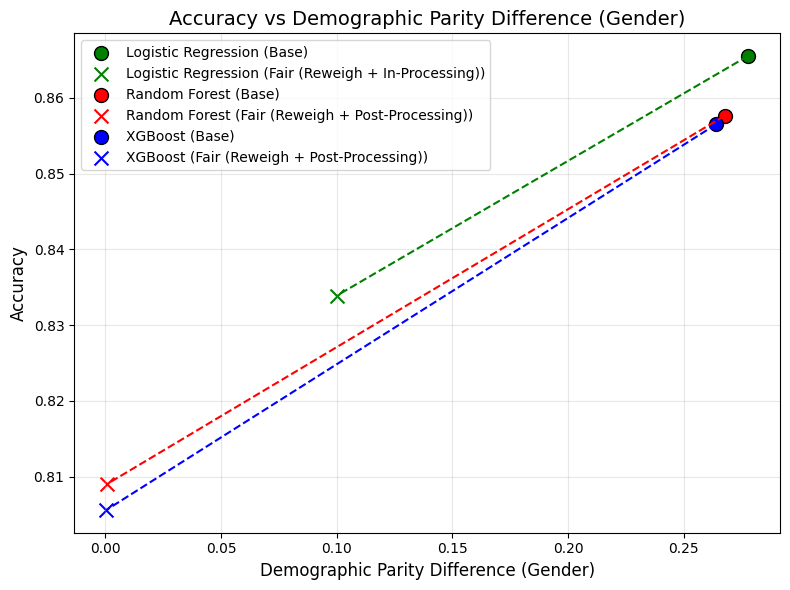

In [101]:
fair_labels_gender = {
    'LR': 'Fair (Reweigh + In-Processing)',
    'RF': 'Fair (Reweigh + Post-Processing)',
    'XGB': 'Fair (Reweigh + Post-Processing)'
}

plot_accuracy_fairness_tradeoff(accuracy_base, accuracy_fair_gen,
                                demographic_parity_base, demographic_parity_fair,
                                'Demographic Parity Difference', 'Gender',
                                fair_labels_gender)


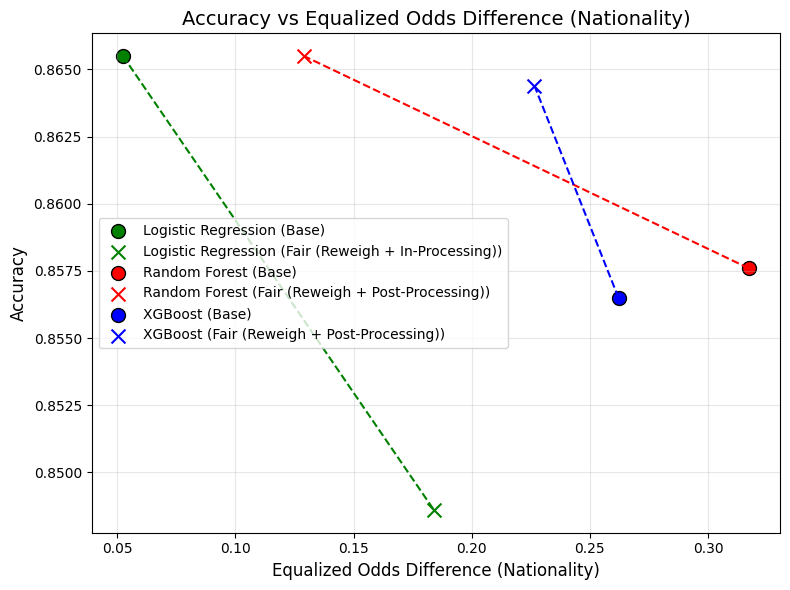

In [100]:
fair_labels_nat = {
    'LR': 'Fair (Reweigh + In-Processing)',
    'RF': 'Fair (Reweigh + Post-Processing)',
    'XGB': 'Fair (Reweigh + Post-Processing)'
}

plot_accuracy_fairness_tradeoff(accuracy_base, accuracy_fair_nat,
                                equalized_odds_base, equalized_odds_fair,
                                'Equalized Odds Difference', 'Nationality',
                                fair_labels_nat)
